In [30]:
import numpy as np
from matplotlib import pyplot as plt
from urllib import request
import gzip
import pandas as pd
from os import path
import csv

dpath = "jpligsac/"

In [31]:
# Download the file (if we don't have it already)
def download_data(week, day):
    url = "https://sideshow.jpl.nasa.gov/pub/jpligsac/" + str(week) + "/"
    filename_base = "jpl" + str(week) + str(day)
    clk_fname = filename_base + ".clk.gz"
    orb_fname = filename_base + ".sp3.gz"
    # download clock data:
    if not path.isfile(dpath + clk_fname):
        downloaded_file, _ = request.urlretrieve(
            url + clk_fname,
            dpath + clk_fname,
        )
        assert downloaded_file == dpath + clk_fname
    # download orbit data:
    if not path.isfile(dpath + orb_fname):
        downloaded_file, _ = request.urlretrieve(
            url + orb_fname,
            dpath + orb_fname,
        )
        assert downloaded_file == dpath + orb_fname
    return filename_base

In [43]:
def find_line_containing(file, the_string) -> int:
    for num, line in enumerate(file, 1):
        if the_string in line:
            return num


def convert_time(row, day):
    return (
        row["Day"] * 24.0 * 60.0 * 60.0
        + row["Hour"] * 60.0 * 60.0
        + row["Minute"] * 60.0
        + row["Second"]
        - day * 24.0 * 60.0 * 60.0
    )


def get_data(filename):
    """Return pandas dataframe of all clock data"""
    unziped = gzip.open(dpath + filename + ".clk.gz", "rt")
    _ = find_line_containing(unziped, "END OF HEADER")
    data = pd.read_csv(
        unziped,
        delimiter=" ",
        skipinitialspace=True,  # Interpret multiple spaces as 1 delimiter
        names=(  # Optional: give meaningful names to each column of data file:
            "Type",  # AR=Reciever, AS=Satellite
            "PRN",  # "PRN" clode for each sattelite
            "Year",  # time stamp
            "Month",
            "Day",
            "Hour",
            "Minute",
            "Second",
            "ncols",  # always 2
            "Bias",  # Bias (s): main data
            "FError",  # "Formal Error" - not very meaningful
        ),
    )
    keywords = {"day": data["Day"].iloc[0]}
    data["Time"] = data.apply(convert_time, axis=1, **keywords)
    return data[data.Type == "AS"]


def get_orbits(filename):
    """Return pandas dataframe of all orbit data"""
    return pd.read_csv(
        dpath + filename + ".sp3.gz",
        skiprows=22,  # hopefully always the same *fingers crossed emoji*
        delimiter=" ",
        on_bad_lines="skip",
        comment="*",
        skipinitialspace=True,
        usecols=[i for i in range(4)],
        quoting=csv.QUOTE_NONE,
        names=(
            "PRN",
            "x",
            "y",
            "z",
        ),
    )[:-1]

In [47]:
week, day = 2299, 0
fname = download_data(week, day)
data = get_data(fname)
orbits = get_orbits(fname)

In [48]:
print(orbits)

       PRN             x             y             z
0     PG01  17696.842082   5572.248564  18803.074206
1     PG02  20238.466727  10907.848102  14014.656109
2     PG03  16278.766463  -1040.931085  20793.925142
3     PG04  26448.447715   1767.236834   2597.362270
4     PG05 -11098.943306 -11148.827284 -21558.135727
...    ...           ...           ...           ...
8954  PG28   1445.797039  21284.964765  15800.264567
8955  PG29 -25060.057464   4678.475996  -7684.397828
8956  PG30   4792.738173 -17997.386729 -18712.725189
8957  PG31   8259.489337  23722.716143   7757.745493
8958  PG32  -9420.058080  14692.195048  20157.520499

[8959 rows x 4 columns]


In [65]:
# Get "good" clocks: no missing data
t_PRNs = np.sort(data["PRN"].unique())
PRNs = []
for prn in t_PRNs:
    tbias = data[data["PRN"] == prn]["Bias"]
    ttime = data[data["PRN"] == prn]["Time"]
    if tbias.size == 2881 and ttime.size == tbias.size:
        PRNs.append(prn)
PRNs = np.array(PRNs)

print(PRNs)

['G01' 'G02' 'G03' 'G04' 'G06' 'G07' 'G09' 'G10' 'G11' 'G12' 'G14' 'G15'
 'G16' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24' 'G25' 'G26' 'G28' 'G30'
 'G31' 'G32']


In [74]:
tau0 = 30.0
dws = np.array([np.diff(data[data.PRN == prn]["Bias"]) / tau0 for prn in PRNs])
t = data[data.PRN == PRNs[0]]["Time"][:-1].to_numpy()
sigmas = np.array([np.std(dw) for dw in dws])

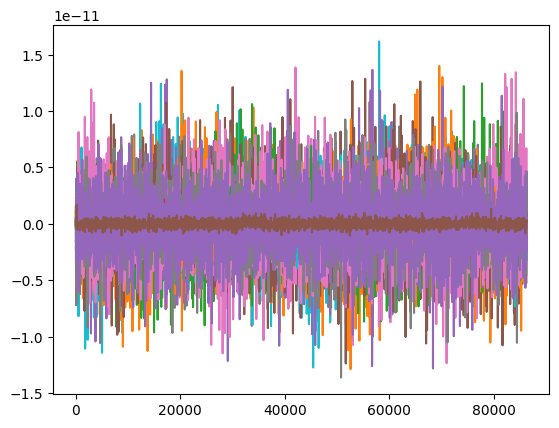

In [72]:
for dw in dws:
    plt.plot(t, dw - np.mean(dw))
plt.show()

In [84]:
def calculate_distance(d1, d2):
    return (
        np.sqrt(
            (d1["x"].to_numpy() - d2["x"].to_numpy()) ** 2
            + ((d1["y"].to_numpy() - d2["y"].to_numpy()) ** 2)
            + ((d1["z"].to_numpy() - d2["z"].to_numpy()) ** 2)
        )
        / 10000
    )

(19, 2)


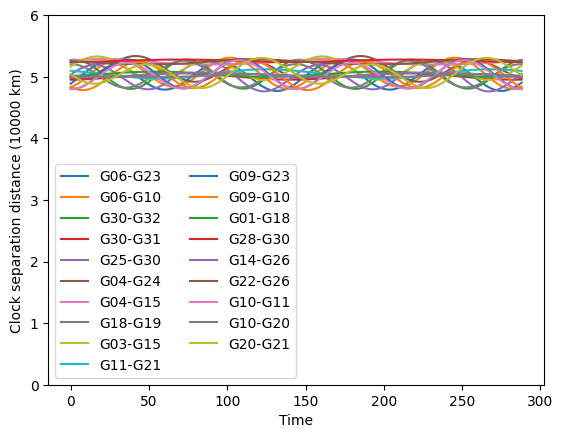

In [156]:
# List clocks by noise
indexes = np.argsort(sigmas)

# only choose pairs that are at least 5 (*10000) km apart on average
min_distance = 5.0
# Ant that have an amplitude < 5% of their maximum
max_std = 0.05

good_pairs = []
for i0 in indexes:
    clock0 = PRNs[i0]
    d0 = orbits[orbits["PRN"] == "P" + clock0]
    for i1 in indexes:
        if i1 <= i0:  # only include each pair once
            continue
        clock_i = PRNs[i1]
        d_i = orbits[orbits["PRN"] == "P" + clock_i]

        dr = calculate_distance(d0, d_i)

        amp = 0.5 * (np.max(dr) - np.min(dr))
        good_pair = np.mean(dr) > min_distance and amp < max_std * np.mean(dr)

        if good_pair:
            # good_pairs.append([i0, i1, clock0, clock_i, sigmas[i0], sigmas[i1]])
            good_pairs.append([i0, i1])

            plt.plot(dr, label=clock0 + "-" + clock_i)
good_pairs = np.array(good_pairs)

print(good_pairs.shape)
# nb: some clocks appear twice. That's fine, we just average each pair!
# print(good_pairs)

plt.xlabel("Time")
plt.ylabel("Clock separation distance (10000 km)")
plt.ylim(0, 6)
plt.legend(ncols=2)
plt.show()

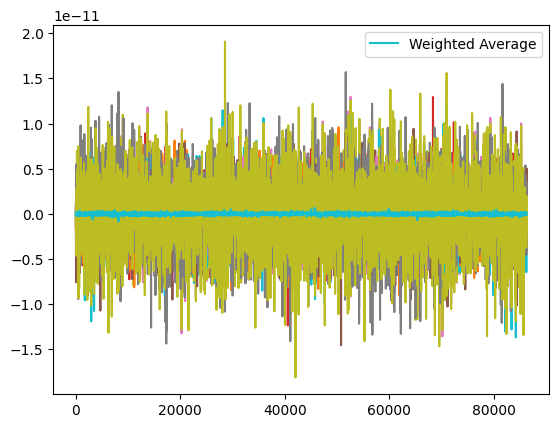

In [158]:
dw_avg = np.zeros(2880)
weight = 0.0
for count, [i0, i1] in enumerate(good_pairs):
    # i0 = 0
    # i1 = 1
    dw1 = dws[i0] - dws[i1]
    dw1 = dw1 - np.mean(dw1)
    sig2 = np.var(dw1)

    dw_avg += dw1 / sig2
    weight += 1.0 / sig2
    # if count == 0:
    plt.plot(t, dw1)
dw_avg /= weight

plt.plot(t, dw_avg, label="Weighted Average")
plt.legend()
plt.show()